# Flats
This notebook's a convenient local development tool integrated with python interpreter, interactive browser-based text editor and preliminary started local PostgreSQL DB. Feel free to use this document to easily explore databases filled with [rampart](https://github.com/xXxRisingTidexXx/rampart) miners & parsers. Happy coding!

## Datasets
Required data consists of two parts:
- Training tabular data lies in `training.csv` ;
- Testing (validation) tabular data lies in `testing.csv` .

## Features
- `actual_price` - true flat's price (in USD);
- `utmost_price` - query's price limit (in USD), search results shouldn't exceed this shape;
- `total_area` - overall apartment's area (in square meters);
- `living_area` - flat's living room area (in square meters);
- `kitchen_area` - flat's kitchen area (in square meters);
- `actual_room_number` - true flat's living room amount;
- `desired_room_number` - target room count;
- `actual_floor` - apartment's floor (the ground floor is the floor #1);
- `total_floor` - house's floor count;
- `desired_floor` - target flat's floor;
- `housing` - either a newbuild or a used apartments;
- `ssf` - Subway Station Factor, the score indicating about subway stations nearby;
- `izf` - Industrial Zone Factor, the score indicating about factories & plants nearby;
- `gzf` - Green Zone Factor, the score indicating about parks nearby;
- `relevance` - sample's search quality;
- `query` - sample's group ID.

## Categorical data
All feature categories are sorted according to their ranks.
- `desired_room_number`
    * `whatever` - not matter how many rooms;
    * `1` - 1 room;
    * `2` - 2 rooms;
    * `3` - 3 rooms;
    * `4+` - huge luxurious apartments with many rooms;
- `desired_floor`
    * `whatever` - not matter what floor;
    * `low` - low floors are preferred;
    * `high` - top floors are preferred;
- `housing`
    * `primary` - newbuilds & houses under construction;
    * `secondary` - old & already used apartments;
- `relevance`
    * `terrible` - don't show this thing again!
    * `bad` - poor quality;
    * `so-so` - average result;
    * `good` - quite smart search;
    * `excellent` - the best matches.

In [1]:
from warnings import filterwarnings
from pandas import read_sql, read_csv
from seaborn import distplot, countplot, scatterplot, heatmap
from matplotlib.pyplot import style, rcParams, subplots
from tabulate import tabulate
from sqlalchemy import create_engine
from os import environ
from scipy.stats import zscore
from numpy import abs, exp
from ppscore import matrix
from lightgbm import Dataset, train

In [2]:
filterwarnings('ignore', message='numpy.dtype size changed')
filterwarnings('ignore', message='numpy.ufunc size changed')
%matplotlib inline
style.use('dark_background')
rcParams['figure.facecolor'] = '#111111'
rcParams['axes.facecolor'] = '#111111'
rcParams['axes.edgecolor'] = '#212121'
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#212121'
rcParams['legend.frameon'] = False
colors = [
    '#ffa6b0', 
    '#ff7383',
    '#e02f44',
    '#deb6f2',
    '#ca95e5',
    '#a352cc',
    '#c0d8ff',
    '#8ab8ff',
    '#3274d9'
]

In [3]:
engine = create_engine(environ['RAMPART_DATABASE_DSN'])
with engine.connect() as connection:
    flats = read_sql(
        """
        select id,
               price,
               total_area,
               living_area,
               kitchen_area,
               room_number,
               floor,
               total_floor,
               case
                   when housing = 'primary' then 0
                   else 1
                   end     as housing,
               ssf,
               izf,
               gzf
        from flats
        where city = 'Київ'
        """,
        connection,
        index_col=['id']
    )
most_flats = flats[(abs(zscore(flats)) < 2).all(1)]

In [4]:
def render(frame):
    print(tabulate(frame, headers='keys', tablefmt='psql', numalign='right'))

In [5]:
render(flats.head())

+------+---------+--------------+---------------+----------------+---------------+---------+---------------+-----------+---------+----------+----------+
|   id |   price |   total_area |   living_area |   kitchen_area |   room_number |   floor |   total_floor |   housing |     ssf |      izf |      gzf |
|------+---------+--------------+---------------+----------------+---------------+---------+---------------+-----------+---------+----------+----------|
|    7 |  114000 |           98 |            61 |             15 |             3 |      17 |            17 |         1 | 6.78635 |  2.30436 |  0.12277 |
|    8 |  249000 |           71 |            40 |             26 |             3 |      12 |            26 |         1 |  5.4816 |  2.43574 |  1.45123 |
|   10 |  145000 |           55 |            35 |             25 |             2 |      18 |            20 |         1 | 7.54528 |  1.50954 | 0.796041 |
|   13 |   45000 |           24 |            15 |              5 |             1 |

In [6]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 7 to 10018
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         1857 non-null   float64
 1   total_area    1857 non-null   float64
 2   living_area   1857 non-null   float64
 3   kitchen_area  1857 non-null   float64
 4   room_number   1857 non-null   int64  
 5   floor         1857 non-null   int64  
 6   total_floor   1857 non-null   int64  
 7   housing       1857 non-null   int64  
 8   ssf           1857 non-null   float64
 9   izf           1857 non-null   float64
 10  gzf           1857 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 174.1 KB


In [7]:
render(flats.loc[:, flats.columns != 'housing'].describe())

+-------+---------+--------------+---------------+----------------+---------------+---------+---------------+---------+---------+----------+
|       |   price |   total_area |   living_area |   kitchen_area |   room_number |   floor |   total_floor |     ssf |     izf |      gzf |
|-------+---------+--------------+---------------+----------------+---------------+---------+---------------+---------+---------+----------|
| count |    1857 |         1857 |          1857 |           1857 |          1857 |    1857 |          1857 |    1857 |    1857 |     1857 |
| mean  |  221823 |      92.2467 |        37.599 |        14.7117 |       2.39149 |  10.468 |       18.9919 | 3.78967 | 3.15838 |  2.51554 |
| std   |  276969 |      56.7191 |       40.2136 |        11.1893 |       1.12533 | 7.07291 |       7.83583 | 4.04141 | 4.81509 |  3.42128 |
| min   |   14000 |           20 |             0 |              0 |             1 |       1 |             2 |       0 |       0 |        0 |
| 25%   |   8

In [8]:
print(len(flats[(flats['price'] <= 100000) & (flats['ssf'] >= 2) & (flats['gzf'] >= 2)]), len(flats), sep=' / ')

143 / 1857


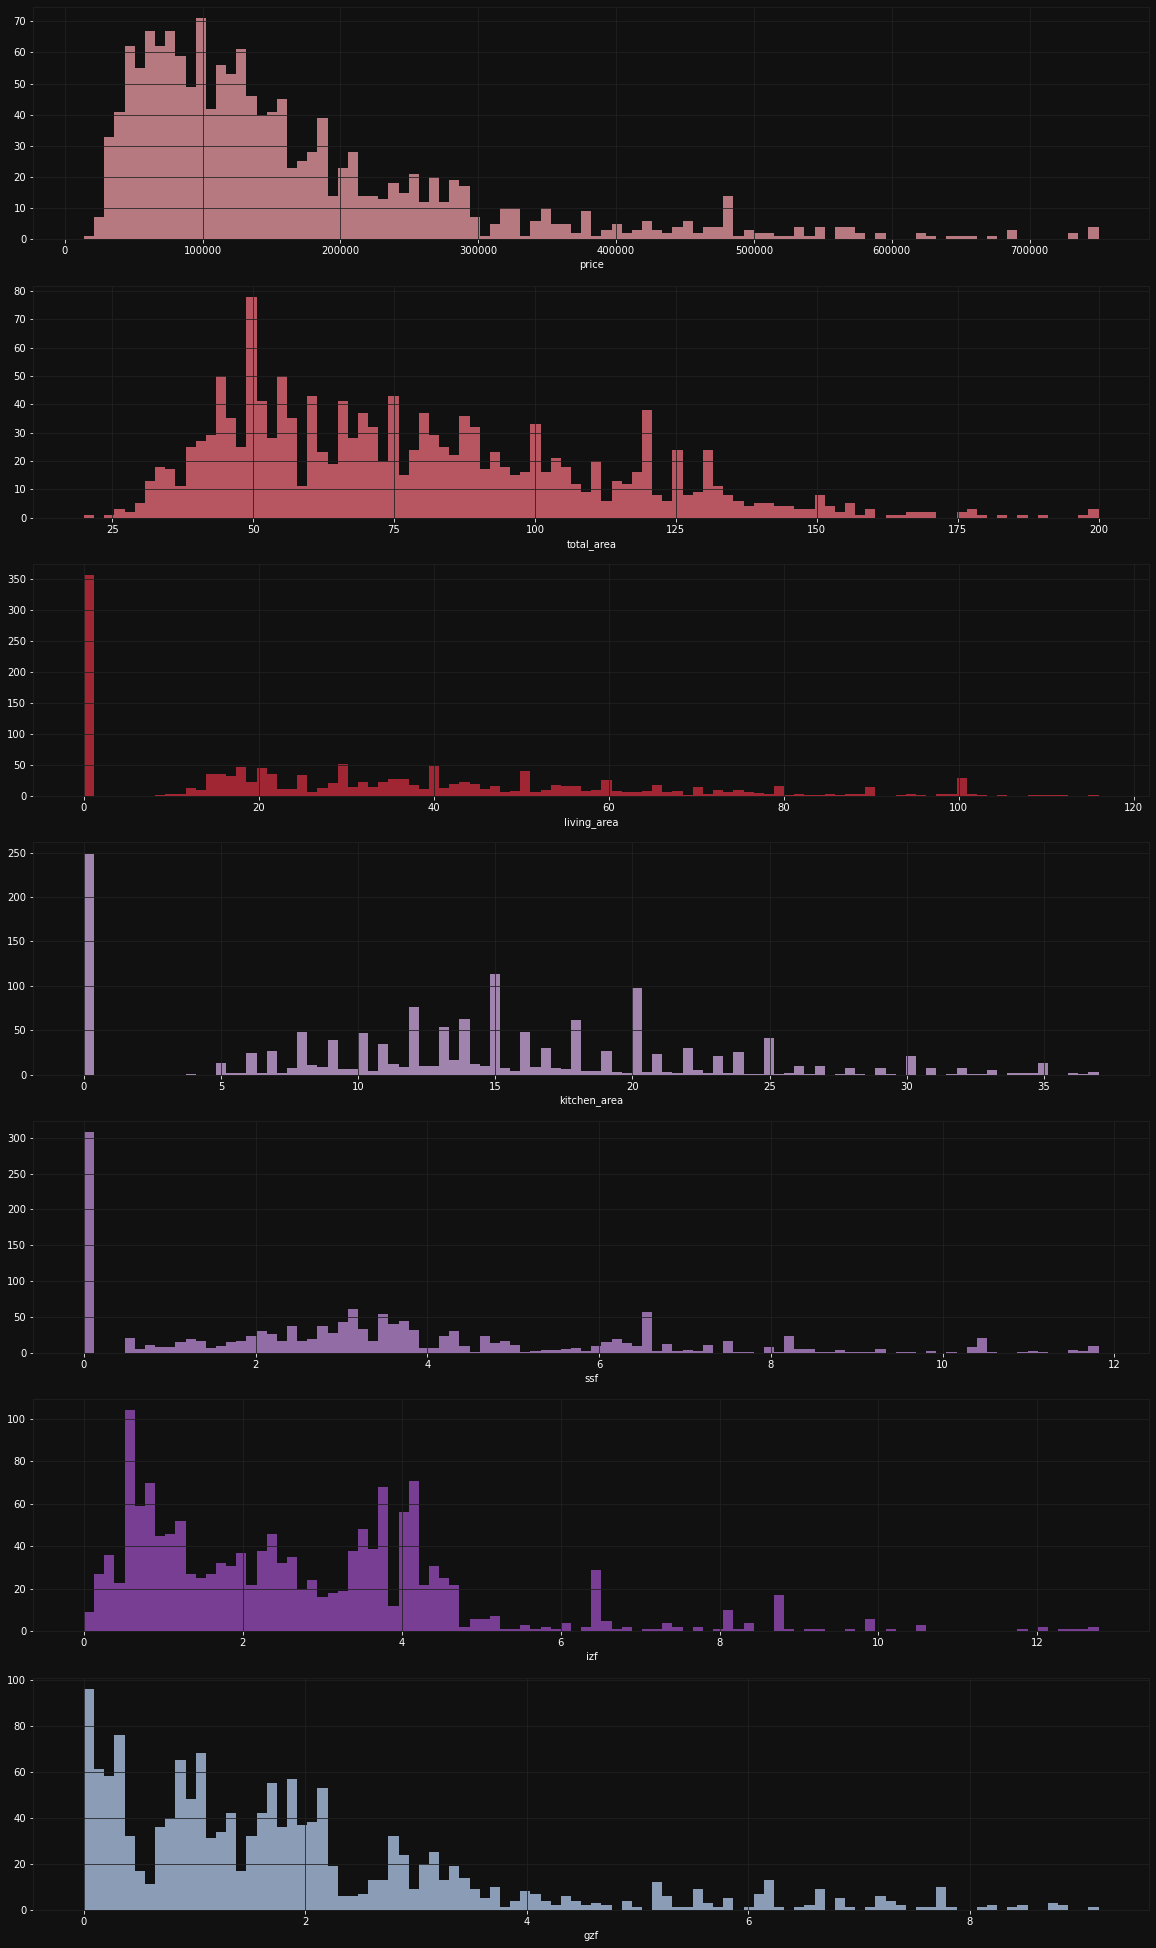

In [9]:
floats = most_flats.select_dtypes(include='float64')
axes = subplots(len(floats.columns), figsize=(20, 5 * len(floats.columns)))[1]
for i, column in enumerate(floats.columns):
    distplot(floats[column], ax=axes[i], color=colors[i], bins=100, kde=False, hist_kws={'alpha': 0.7})

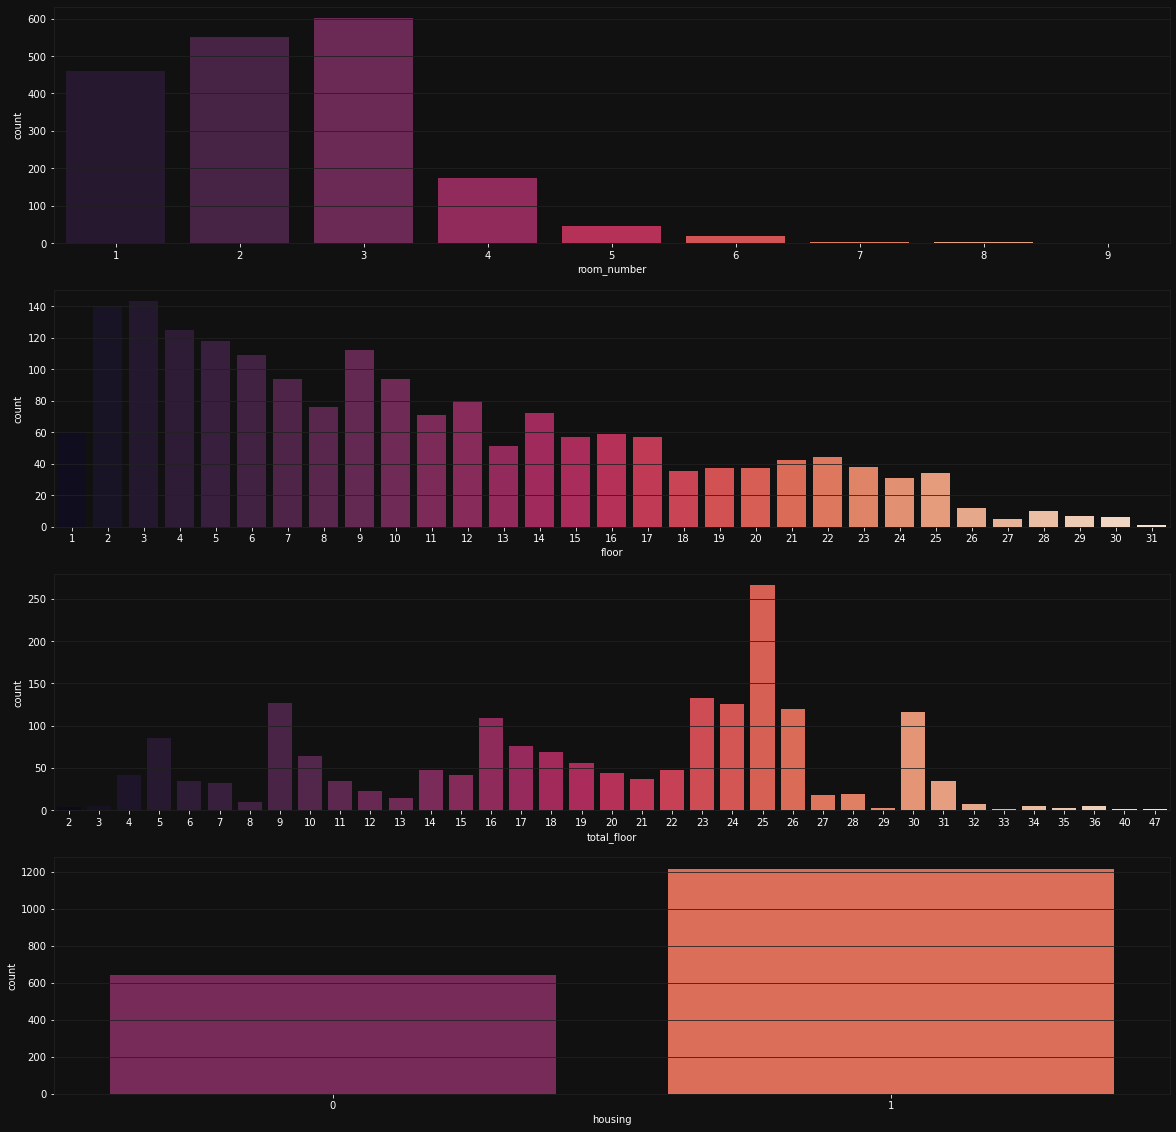

In [10]:
ints = flats.select_dtypes(include='int64')
axes = subplots(len(ints.columns), figsize=(20, 5 * len(ints.columns)))[1]
for i, column in enumerate(ints.columns):
    countplot(flats[column], palette='rocket', ax=axes[i])

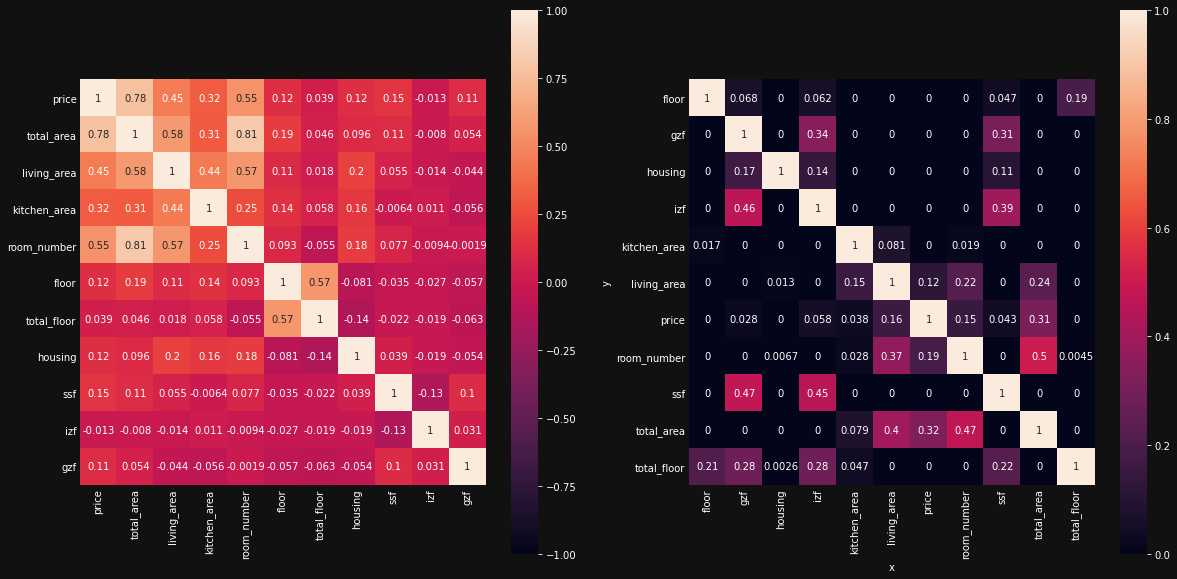

In [11]:
axes = subplots(1, 2, figsize=(20, 10))[1]
for axis in axes:
    axis.tick_params(axis='both', which='both',length=0)
heatmap(
    flats.corr(),
    ax=axes[0],
    vmin=-1,
    vmax=1,
    annot=True,
    square=True,
    cmap='rocket'
)
heatmap(
    matrix(flats)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore'),
    ax=axes[1],
    vmin=0,
    vmax=1,
    annot=True,
    square=True,
    cmap='rocket'
)
pass

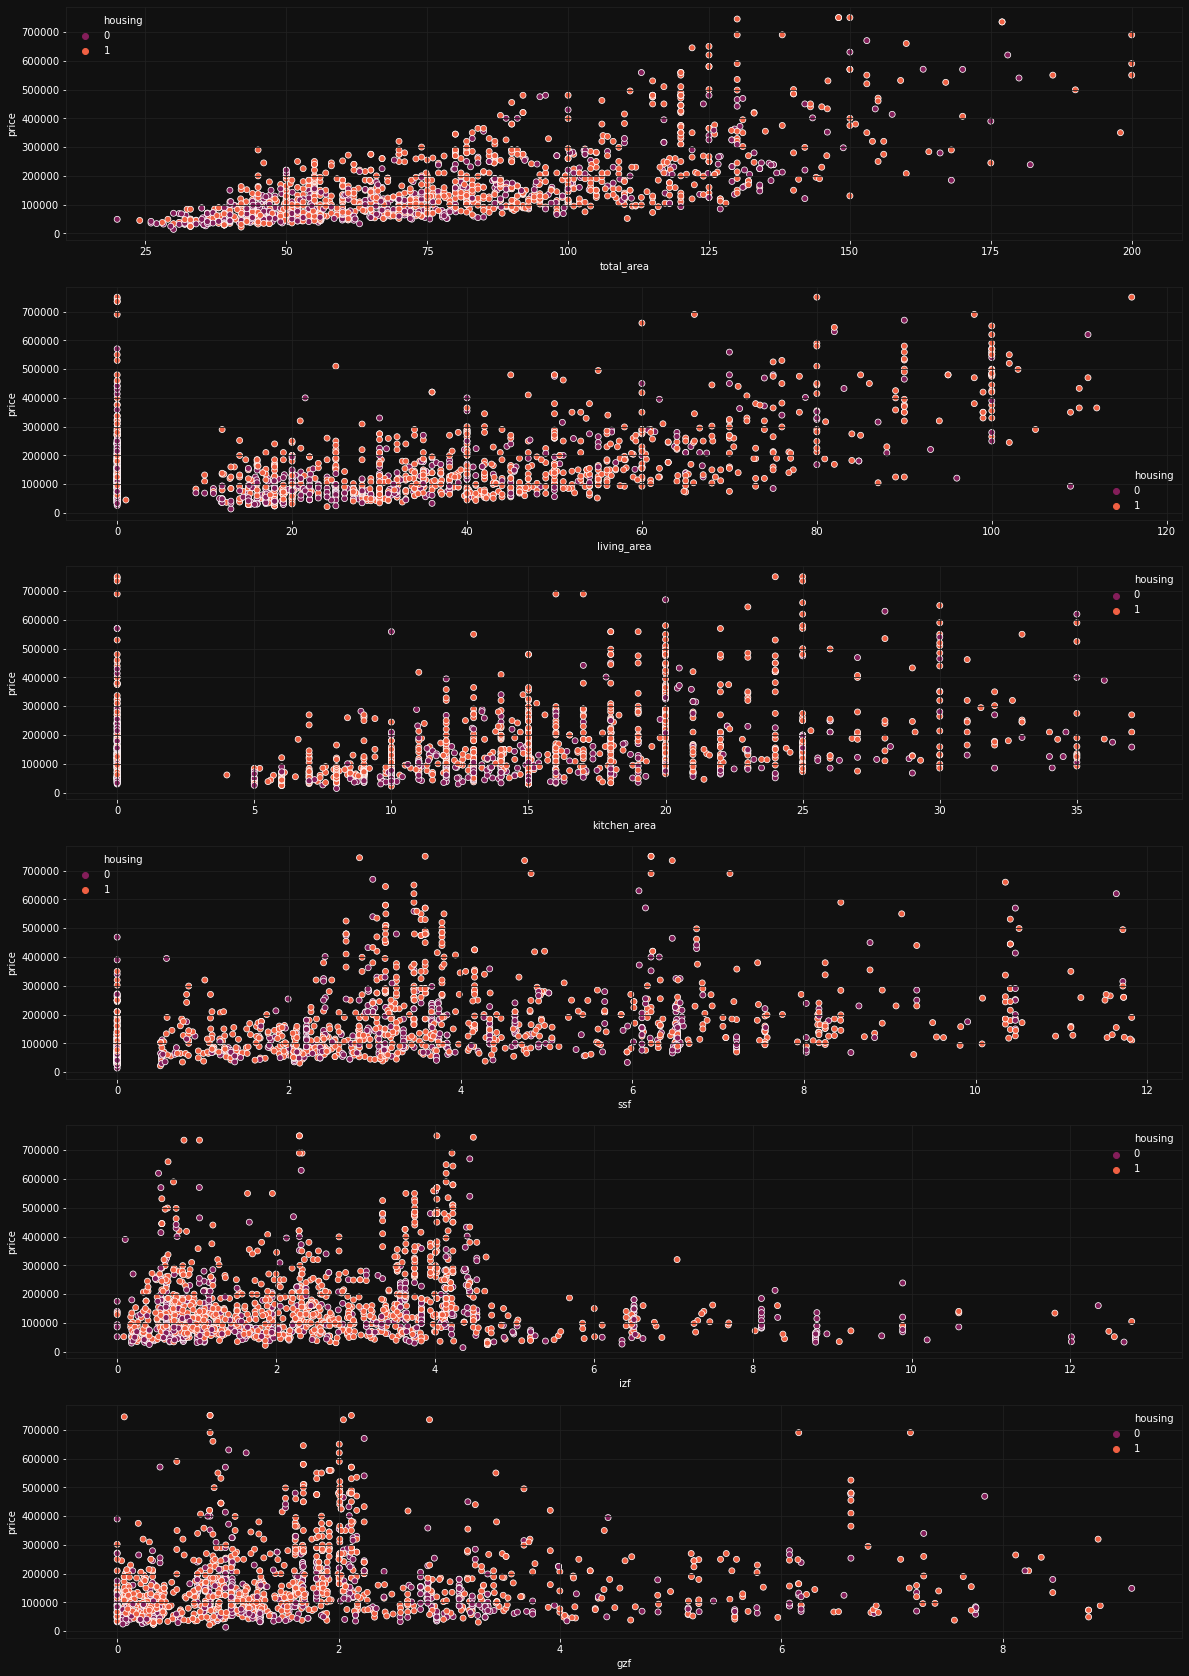

In [12]:
columns = ['total_area', 'living_area', 'kitchen_area', 'ssf', 'izf', 'gzf']
axes = subplots(len(columns), figsize=(20, len(columns) * 5))[1]
for i, column in enumerate(columns):
    scatterplot(column, 'price', 'housing', ax=axes[i], data=most_flats, palette='rocket')

In [13]:
def load(path, params, reference=None):
    frame = read_csv(path)
    return Dataset(
        frame.drop(columns=['relevance', 'query']),
        frame['relevance'],
        group=frame.groupby(['query']).size(),
        categorical_feature=['desired_room_number', 'desired_floor', 'housing'],
        reference=reference,
        params=params
    )

In [14]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg'
}
training = load('../training.csv', params)
testing = load('../testing.csv', params, training)
train(params, training, 30, [testing], early_stopping_rounds=15).save_model('../model.txt')
pass

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 14


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's ndcg@1: 0.681481	valid_0's ndcg@2: 0.561127	valid_0's ndcg@3: 0.610224	valid_0's ndcg@4: 0.616368	valid_0's ndcg@5: 0.636542
Training until validation scores don't improve for 15 rounds
[2]	valid_0's ndcg@1: 0.807407	valid_0's ndcg@2: 0.707112	valid_0's ndcg@3: 0.673786	valid_0's ndcg@4: 0.673082	valid_0's ndcg@5: 0.6551
[3]	valid_0's ndcg@1: 0.807407	valid_0's ndcg@2: 0.738634	valid_0's ndcg@3: 0.753274	valid_0's ndcg@4: 0.750052	valid_0's ndcg@5: 0.720191
[4]	valid_0's ndcg@1: 0.585185	valid_0's ndcg@2: 0.653959	valid_0's ndcg@3: 0.730182	valid_0's ndcg@4: 0.715897	valid_0's ndcg@5: 0.725505
[5]	valid_0's ndcg@1: 0.644444	valid_0's ndcg@2: 0.667369	valid_0's ndcg@3: 0.740445	valid_0's ndcg@4: 0.754325	valid_0's ndcg@5: 0.739453
[6]	valid_0's ndcg@1: 0.525926	valid_0's ndcg@2: 0.640549	valid_0's ndcg@3: 0.719918	valid_0's ndcg@4: 0.722304	valid_0's ndcg@5: 0.723296
[7]	valid_0's ndcg@1: 0.525926	valid_0's ndcg@2: 0.640549	valid_0's ndcg@3: 0.706013	valid_0's ndcg@4: 0.72